# Task 2

---

## Predictive modeling of customer bookings

In this project i try to predict complete customer bookings at British airways based and indentify which variables have the most impact on whether a booking is completed or not.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.First we'll import the necessary libraries then proceed with the analysis.

In [3]:
!pip install xgboost

In [4]:
# importing necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
# Mapping the unique flight_days to numbers for easier analysis.
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [9]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [10]:
# Mapping trip_type

df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [11]:
mapping = {
    "RoundTrip": 1,
    "CircleTrip": 2,
    "OneWay": 3
    
}

df["trip_type"] = df["trip_type"].map(mapping)

In [12]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [13]:
# Mapping sales_channel
mapping = {
    "Internet": 1,
    "Mobile": 2   
}

df["sales_channel"] = df["sales_channel"].map(mapping)

In [14]:
# Using the describe function to get a summary of descriptive statistics for the data.
df.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,1.112360,1.017800,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,0.315812,0.181559,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,1.000000,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,1.000000,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,1.000000,1.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,2.000000,3.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

Convert data types of relevant columns into boolean type to facilitate model training.

In [15]:
df['wants_extra_baggage'] = df['wants_extra_baggage'].astype('bool')
df['wants_preferred_seat'] = df['wants_preferred_seat'].astype('bool')
df['wants_in_flight_meals'] = df['wants_in_flight_meals'].astype('bool')
df['booking_complete'] = df['booking_complete'].astype('bool')

Split the dataset into input features (X) and the target variable (y):

In [16]:
X = df.drop(['booking_complete', 'booking_origin', 'route'], axis=1)
y = df['booking_complete']

Split the data into test and train samples

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First we will train the machine learning model using a Random Forest classifier:

In [18]:
model8 = RandomForestClassifier()
model8.fit(X_train, y_train)

RandomForestClassifier()

Perform cross-validation and calculate evaluation metrics:

In [19]:
cv_scoresy = cross_val_score(model8, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracyy = cv_scoresy.mean()
print(mean_accuracyy)

0.8477


Visualize feature importance:

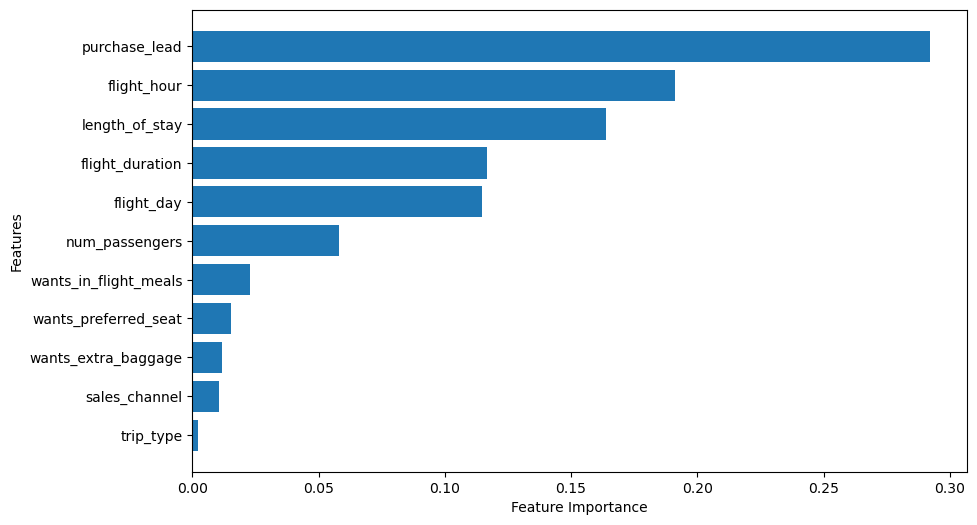

In [20]:
feature_importance = model8.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature Importance': feature_importance}, index=feature_names)

# Sort the DataFrame by feature importance in descending order
sorted_importance_df = importance_df.sort_values(by='Feature Importance', ascending=True)

# Retrieve the sorted feature importances and names
sorted_feature_importance = sorted_importance_df['Feature Importance']
sorted_feature_names = sorted_importance_df.index

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

Print evaluation metrics and feature importance:

In [21]:
print("Mean Accuracy:", mean_accuracyy)
print("Feature Importance:")
for feature, importance in zip(feature_names, feature_importance):
    print(feature, ":", importance)

Mean Accuracy: 0.8477
Feature Importance:
num_passengers : 0.058284608254438354
sales_channel : 0.010642169333275118
trip_type : 0.002261609911846023
purchase_lead : 0.292304638269805
length_of_stay : 0.16399322194450808
flight_hour : 0.19114491853904278
flight_day : 0.11484097120596677
wants_extra_baggage : 0.011670185371084387
wants_preferred_seat : 0.015272966487221963
wants_in_flight_meals : 0.02273566749169933
flight_duration : 0.1168490431911122


In [22]:
# print test accuracy

test_accuracyy = model8.score(X_test, y_test)
print(test_accuracyy)

0.8485


Next we will try the XGB classifier

In [24]:
# Define and train the XGBoost model on the training data:

model4 = xgb.XGBClassifier()
model4.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Perform cross-validation on the training set:

In [25]:
cv_scores3 = cross_val_score(model4, X_train, y_train, cv=5, scoring='accuracy')
mean_accuracy3 = cv_scores3.mean()

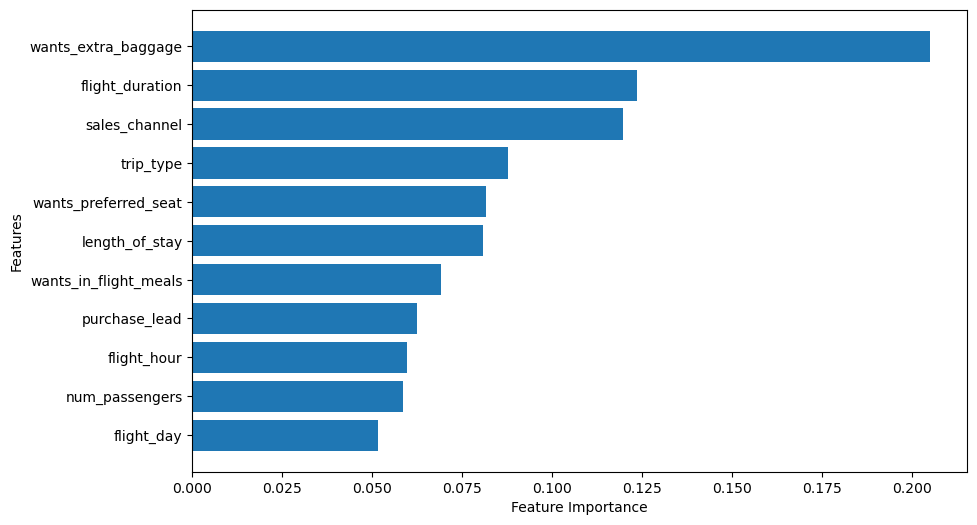

In [26]:
feature_importance = model4.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature Importance': feature_importance}, index=feature_names)

# Sort the DataFrame by feature importance in descending order
sorted_importance_df = importance_df.sort_values(by='Feature Importance', ascending=True)

# Retrieve the sorted feature importances and names
sorted_feature_importance = sorted_importance_df['Feature Importance']
sorted_feature_names = sorted_importance_df.index

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

Evaluate the model on the testing set:

In [27]:
print("Mean Accuracy:", mean_accuracy3)
print("Feature Importance:")
for feature, importance in zip(feature_names, feature_importance):
    print(feature, ":", importance)

Mean Accuracy: 0.8466250000000001
Feature Importance:
num_passengers : 0.05863066
sales_channel : 0.119724944
trip_type : 0.08771105
purchase_lead : 0.062389866
length_of_stay : 0.08091676
flight_hour : 0.059641365
flight_day : 0.051507805
wants_extra_baggage : 0.20511554
wants_preferred_seat : 0.081553824
wants_in_flight_meals : 0.06923997
flight_duration : 0.12356816


## RESULTS

According to the results from the models shown above the Random forest classifier model  gives a more accurate prediction with 0.848 accuracy levels and the 4 most important features with regard to customer booking prediction are :

- Purchase lead time
- No of flight hours
- Length of stay
- Flight duration